In [1]:
import folium
import pandas as pd
import json
import re
from branca.colormap import linear
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, output_file

# output_notebook

df = pd.read_csv("assessment_statistics.csv")
df["Pass Rate"] = pd.to_numeric(df["Pass Rate"])

by_county = pd.read_csv("by_county.csv")
by_county["Pass Rate"] = pd.to_numeric(df["Pass Rate"])

df2 = by_county.set_index('Division Name')
df2_dict = df2["Pass Rate"]

wealth_df = pd.read_csv("by_county_income.tsv", sep='\t')
wealth_df['median_household_income'] = pd.to_numeric(wealth_df.median_household_income)
wealth_df['name'] = wealth_df['_name'] + ' ' + wealth_df['type']
wealth_df['Division Name'] = wealth_df['name']
wealth_dict = wealth_df.set_index('name')

all_df = pd.merge(wealth_df, by_county, on='Division Name', how='outer')
del all_df['rank'], all_df['_name'], all_df['type']

sent = object()

def _mapfn(x):
    new_x = x.copy()
    new_x['properties']['NAME'] += ' ' + new_x['properties']['LSAD'].capitalize()
    try:
        new_x['properties']['PASS_RATE'] = df2_dict[new_x['properties']['NAME']]
    except KeyError:
        new_x['properties']['PASS_RATE'] = 'Unknown'

    try:
        new_x['properties']['WEALTH'] = wealth_dict[new_x['properties']['NAME']]
    except KeyError:
        new_x['properties']['WEALTH'] = 'Unknown'
    
    if new_x['properties']['NAME'] not in df["Division Name"].values:
        new_x['properties']['NAME'] = 'Unknown'
        return sent
    else:
        return new_x

with open('thing.json') as f, open('VA_Counties.json', 'w') as g:
    counties = {
        'type': 'FeatureCollection', # (_mapfn(x) for x in json.load(f)['features'] if x['properties']['STATE'] == '51') 
        'features': list(filter(lambda x: x != sent, (_mapfn(x) for x in json.load(f)['features'] if x['properties']['STATE'] == '51')))
    }
    json.dump(counties, g)

In [2]:
# df2 = df.groupby('Division Name').median()
# df2['Division Name'] = df.index
# df2["Division Name"] = df2.index
# df2_dict = df2["Pass Rate"]
# df2_dict
all_df.set_index('name')['median_family_income']['Alleghany Highlands County']

KeyError: 'Alleghany Highlands County'

In [35]:
# df2 = by_county.set_index('Division Name')
# df2_dict = df2["Pass Rate"]
all_df.sort_values('name')

,per_capita_income,median_household_income,median_family_income,population,num_of_households,name,Division Name,School Year,Division Number,Subject,Pass Rate
85,22766.0,41372.0,49727.0,33164.0,13798.0,Accomack County,Accomack County,2018-2019,1.0,Mathematics,78.60
27,36685.0,64847.0,83894.0,98970.0,38157.0,Albemarle County,Albemarle County,2018-2019,2.0,Mathematics,83.39
10,54345.0,80847.0,102017.0,139966.0,68082.0,Alexandria City,Alexandria City,2018-2019,101.0,Mathematics,79.30
77,22013.0,43160.0,53205.0,16250.0,6891.0,Alleghany County,Alleghany County,2018-2019,3.0,Mathematics,89.19
55,24197.0,50135.0,58029.0,12690.0,4821.0,Amelia County,Amelia County,2018-2019,4.0,Mathematics,91.33
...,...,...,...,...,...,...,...,...,...,...,...
9,35823.0,81055.0,92597.0,65464.0,24006.0,York County,York County,2018-2019,98.0,Mathematics,74.78
134,NaN,NaN,NaN,NaN,NaN,NaN,Arlington County,2018-2019,7.0,Mathematics,86.07
135,NaN,NaN,NaN,NaN,NaN,NaN,Colonial Beach,2018-2019,202.0,Mathematics,82.93
136,NaN,NaN,NaN,NaN,NaN,NaN,West Point,2018-2019,207.0,Mathematics,84.40


In [3]:
my_map = folium.Map(location=[37.654267, -78.518069], zoom_start=8)

ch = folium.Choropleth(
    geo_data=counties,
    data=by_county,
    columns=["Division Name", "Pass Rate"],
    key_on='feature.properties.NAME',
    fill_color="RdBu",
    legend_name="Mathematics SOL Pass Rate (%)",
    highlight=True,
    name=True
).add_to(my_map)

folium.GeoJsonTooltip(
    fields=['NAME', 'PASS_RATE'],
    sticky=False
).add_to(ch.geojson)

my_map.save("counties.html")
my_map

In [4]:
wealth_map = folium.Map(location=[37.654267, -78.518069], zoom_start=8)

ch = folium.Choropleth(
    geo_data=counties,
    data=wealth_df,
    columns=["name", "median_household_income"],
    key_on='feature.properties.NAME',
    fill_color="RdBu",
    legend_name="Median Household Income ($)",
    highlight=True,
    name=True
).add_to(wealth_map)

folium.GeoJsonTooltip(
    fields=['NAME', 'WEALTH'],
    sticky=False
).add_to(ch.geojson)

wealth_map.save("counties_by_wealth.html")
wealth_map

In [4]:
wealth_map = folium.Map(location=[37.654267, -78.518069], zoom_start=8)

ch = folium.Choropleth(
    geo_data=counties,
    data=wealth_df,
    columns=["name", "median_household_income"],
    key_on='feature.properties.NAME',
    fill_color="RdBu",
    legend_name="Median Household Income ($)",
    highlight=True,
    name=True
).add_to(wealth_map)

folium.GeoJsonTooltip(
    fields=['NAME', 'WEALTH'],
    sticky=False
).add_to(ch.geojson)

wealth_map.save("counties_by_wealth.html")
wealth_map

In [ ]:
my_map = folium.Map(location=[37.654267, -78.518069], zoom_start=8)
colormap = linear.RdBu_09.scale(df2["Pass Rate"].min(), df2["Pass Rate"].max())
folium.GeoJson(
    counties,
    name="Pass Rate",
    style_function=lambda feature: {
        "fillColor": colormap(df2_dict[feature["properties"]["NAME"]]),
        "color": "black",
        "weight": 1,
        "dashArray": "5, 5",
        "fillOpacity": 0.9
    }
).add_to(my_map)

folium.LayerControl().add_to(my_map)
colormap.caption = "SOL Pass Rates"
colormap.add_to(my_map)
# my_map.save("map.html")
my_map

In [ ]:
wealth_map = folium.Map(location=[37.654267, -78.518069], zoom_start=8)
colormap = linear.RdBu_09.scale(wealth_df.median_household_income.min(), wealth_df.median_household_income.max())

folium.GeoJson(
    counties,
    name="median_household_income",
    style_function=lambda feature: {
        "fillColor": colormap(wealth_dict[feature["properties"]["NAME"]]),
        "color": "black",
        "weight": 1,
        "dashArray": "5, 5",
        "fillOpacity": 0.9
    }
).add_to(wealth_map)

folium.LayerControl().add_to(wealth_map)
colormap.caption = "SOL Pass Rates"
colormap.add_to(wealth_map)
wealth_map

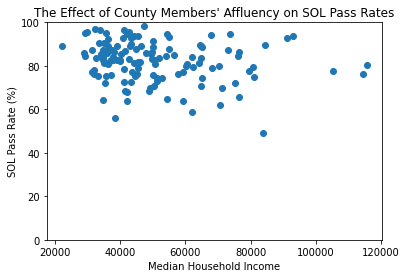

In [30]:
%matplotlib inline
plt.figure()
plt.scatter(all_df['median_household_income'], all_df['Pass Rate'])
plt.ylim([0, 100])
plt.ylabel("SOL Pass Rate (%)")
plt.xlabel("Median Household Income")
plt.title("The Effect of County Members' Affluency on SOL Pass Rates")
plt.show()

In [21]:
all_df.to_csv("all.csv")

In [7]:
pd.read_excel('excel/education/education.xlsm')

,Division Name,Pass Rate
0,Accomack County,80.65
1,Albemarle County,81.37
2,Alexandria City,70.32
3,Alleghany County,69.14
4,Amelia County,86.13
...,...,...
127,Williamsburg-James City County,85.63
128,Winchester City,77.05
129,Wise County,93.24
130,Wythe County,89.80
